# Calculating Salt Flux in the Delaware Estuary

#### This code will demonstrate how to use COAWST model output to calculate salt flux from the mouth of the Delaware Bay estuary located on the eastern seaboard of the U.S. The code is specific to analyzing output on a supercomputer where the data is stored. Use this as a template for calculating salt flux, your own code will look different
##### Contact: secook@usgs.gov

In [30]:
# Import relevant packages
import xarray as xr
import xarray.ufuncs as xu
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cmocean as cm
import dask.array as da
import pandas as pd

In [2]:
# It is suggested to parallelize these steps if your data is large (this dataset is ~2TB), the following steps use Dask 
from distributed import Client
# I started a client on the supercomputer and this is specifying the IP of that cluster. 
client = Client('127.0.0.1:43576')

## Load Model Data

In [3]:
# This code will consolidate several netcdf files on the USGS THREDDS server as an Xarray Data Array (https://docs.xarray.dev/en/stable/)
ds1 = xr.open_mfdataset('/vortexfs1/share/usgs-share/users/scook/proj/DE_Bay/run07/run07C/testcoawst/tide/model_output/ocean_deb_his_run07C_tsvar_testcoawst_tide_000*.nc',
                      concat_dim='ocean_time',
                      data_vars='minimal', coords='minimal', compat='override',
                      parallel=True, chunks={'ocean_time':1})

## Create a few functions

#### This version I got from https://stackoverflow.com/questions/62797088/xr-apply-ufunc-to-filter-3d-x-array

In [4]:
from scipy import signal

In [5]:
Cf = 32
fs = 1
order_butter=6

In [6]:
def butter_filt(x,Cf,fs,order_butter):
    #Cf = is the half amplitude in hours
    #fs = is the sample interval in hours
    #fn = fs/2; # Nyquist Frequency
    fc = (1/Cf)/2 # cut off frequency
    b, a = signal.butter(order_butter, fc, 'low', fs=fs, output='ba')

    return signal.filtfilt(b, a, x)


def filtfilt_butter(x,Cf,fs,order_butter,dim='ocean_time'):
    # x ...... xr data array
    # dims .... dimension aong which to apply function    
    filt= xr.apply_ufunc(
        butter_filt,  # first the function
        x,# now arguments in the order expected by 'butter_filt'
        Cf,  # as above
        fs,  # as above
        order_butter,  # as above
        input_core_dims=[["depth","km","time"], [], [],[]],  # list with one entry per arg
        output_core_dims=[["depth","km","time"]],  # returned data has 3 dimension
        exclude_dims=set(("time",)),  # dimensions allowed to change size. Must be a set!
        vectorize=True)  # loop over non-core dims)

    return filt

## Calculate vertical positions z_r and z_w and cell thickness, Hz

In [7]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url="https://www.myroms.org/wiki/images/4/41/vertical_grid.png")

In [8]:
N = len(ds1['s_rho'])
dx = 1/ds1['pm']
dy = 1/ds1['pn']
h = ds1['h']
hc = ds1['hc']
Np = N+1
dss = 1/N
theta_s = ds1['theta_s']
theta_b = ds1['theta_b']
s_rho = ds1['s_rho']

In [9]:
# Calculate Stretching - but if theta_s and theta_b are 0 I think s=s_rho and C=Cs_r
# RHO POINTS
Nlev = N
lev = np.arange(1,N+1)-0.5
sr = (lev-N)*dss
sr = xr.DataArray(sr,dims=['s_rho'],coords={'s_rho':ds1['s_rho']})
        
if theta_s>0:
    Csur=(1.0-cosh(theta_s*s))/(cosh(theta_s)-1.0)
else:
    Csur=-sr**2;

if (theta_b > 0):
    Cbot=(exp(theta_b*Csur)-1.0)/(1.0-exp(-theta_b))
    C=Cbot;
else:
    C=Csur

Cr = xr.DataArray(C,dims=['s_rho'],coords={'s_rho':ds1['s_rho']})

Zo_rho = ( ds1.hc * sr + Cr * ds1.h ) / ( ds1.hc + ds1.h )
z_rho  = ds1.zeta + ( ds1.zeta + ds1.h ) * Zo_rho
ds1.coords['z_rho'] = z_rho.transpose()

In [10]:
# Calculate Stretching - but if theta_s and theta_b are 0 I think s=s_rho and C=Cs_
# W POINTS
Nlev = Np
lev = np.arange(0,Nlev)
sw = (lev-N)*dss
sw = xr.DataArray(sw,dims=['s_w'],coords={'s_w':ds1['s_w']})
        
if theta_s > 0:
    Csur=(1.0-cosh(theta_s*s))/(cosh(theta_s)-1.0)
else:
    Csur=-sw**2;

if (theta_b > 0):
    Cbot=(exp(theta_b*Csur)-1.0)/(1.0-exp(-theta_b))
    C=Cbot;
else:
    C=Csur
    
Cw = xr.DataArray(C,dims=['s_w'],coords={'s_w':ds1['s_w']})

Zo_w = ( ds1.hc * sw + Cw * ds1.h ) / ( ds1.hc + ds1.h )
z_w  = ds1.zeta + ( ds1.zeta + ds1.h ) * Zo_w
ds1.coords['z_w'] = z_w.transpose()

## Establish the indices for mouth transect - this will lower calculation time down the road

In [11]:
x = np.arange(48,108,1)
y = np.arange(57,69,1)
y = np.repeat(y,5)

In [12]:
print(len(x),len(y))

60 60


In [13]:
target_x = xr.DataArray(x,dims=["points"])
target_y = xr.DataArray(y,dims=["points"])

In [14]:
lon = ds1['lon_rho'].isel(xi_rho=target_x,eta_rho=target_y)
lat = ds1['lat_rho'].isel(xi_rho=target_x,eta_rho=target_y)

(-75.6336721410152, -74.5539997447622, 38.57677062757692, 40.22643263298771)

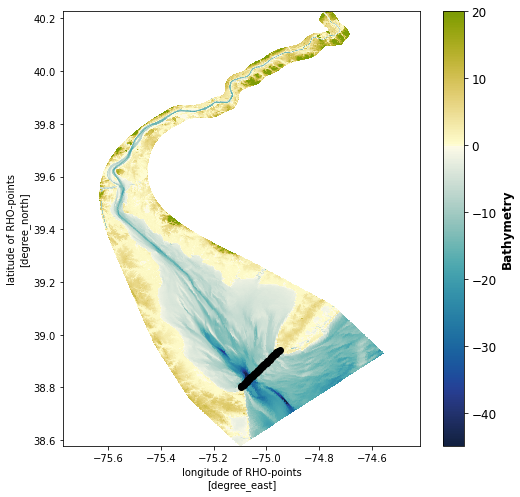

In [15]:
fig,ax1 = plt.subplots(figsize=(8,8))

newcmap = cm.cm.tools.crop(cm.cm.delta,vmin=-45,vmax=20,pivot=0)

da = -1*ds1['h']
p1 = da.plot(ax=ax1,x='lon_rho', y='lat_rho',cmap=newcmap,vmin=-45,vmax=20,add_colorbar=False)

cb = plt.colorbar(p1,ax=ax1)
cb.set_label(label="Bathymetry",size='large',weight='bold')
cb.ax.tick_params(labelsize='large')

plt.plot(lon,lat,'ko')

#fig.tight_layout()
ax1.axis('equal')

#### Calculate Hz - cell thickness

In [16]:
dz = ds1['z_w'].isel(xi_rho=target_x,eta_rho=target_y).compute()

In [17]:
Hz = dz.diff(n=1,dim='s_w').swap_dims({'s_w':'s_rho'})

#### Calculate dx - cell width

In [18]:
dx =  1/ds1['pm'].isel(xi_rho=target_x,eta_rho=target_y).compute()

#### Calculate Area

In [19]:
dA = dx*Hz

# Calculate Salt Flux
##### Following Aristizabal and Chant 2013

$ \LARGE F_s = \left\langle \iint v s \, \mathrm{d}A \right\rangle = F_0 + F_E + F_t $

In [20]:
nt = len(ds1['ocean_time'])

the persist() from above might affect this computation...

In [21]:
vi = ds1['v'].isel(xi_v=target_x,eta_v=target_y).chunk({'ocean_time':nt}).persist()

In [22]:
si = ds1['salt'].isel(xi_rho=target_x,eta_rho=target_y).chunk({'ocean_time':nt}).persist()

In [23]:
dA = dx*Hz

In [24]:
Ao = xr.apply_ufunc(filtfilt_butter,
                   (dA.sum(axis=0).sum(axis=0)).chunk(dict(ocean_time=-1)),
                   Cf,
                   fs,
                   order_butter,
                   'ocean_time', 
                   dask='parallelized',
                   #vectorize=True,
                   #allow_rechunk=True,
                   input_core_dims=[["ocean_time"],[],[],[],[]],  # list with one entry per arg
                   output_core_dims=[["ocean_time"]],  # returned data has one dimension   
                   output_dtypes=[Hz.dtype])  # one per output

In [25]:
dAo = xr.apply_ufunc(filtfilt_butter,
                   dA.chunk(dict(ocean_time=-1)),
                   Cf,
                   fs,
                   order_butter,
                   'ocean_time', 
                   dask='parallelized',
                   #vectorize=True,
                   #allow_rechunk=True,
                   input_core_dims=[["ocean_time"],[],[],[],[]],  # list with one entry per arg
                   output_core_dims=[["ocean_time"]],  # returned data has one dimension   
                   output_dtypes=[Hz.dtype])  # one per output

### 1. River Salt Flux
$ \large F_0 = -Q_0 S_0 = -v_0 A_0 s_0$

$ \large v_0 (t) = \frac{1}{A_0} \left\langle \iint v_i \,  \mathrm{d}A \right\rangle \\
\large s_0 (t) = \frac{1}{A_0} \left\langle \iint s_i \,  \mathrm{d}A \right\rangle$

In [26]:
v0i = (vi*dA).sum(axis=1).sum(axis=1)
s0i = (si*dA).sum(axis=1).sum(axis=1)

In [27]:
Cf = 32
fs = 1
order_butter=6
v0 = butter_filt(v0i,Cf,fs,order_butter)/Ao
s0 = butter_filt(s0i,Cf,fs,order_butter)/Ao

In [28]:
F0 = -1*v0*dAo.sum(axis=0).sum(axis=0)*s0

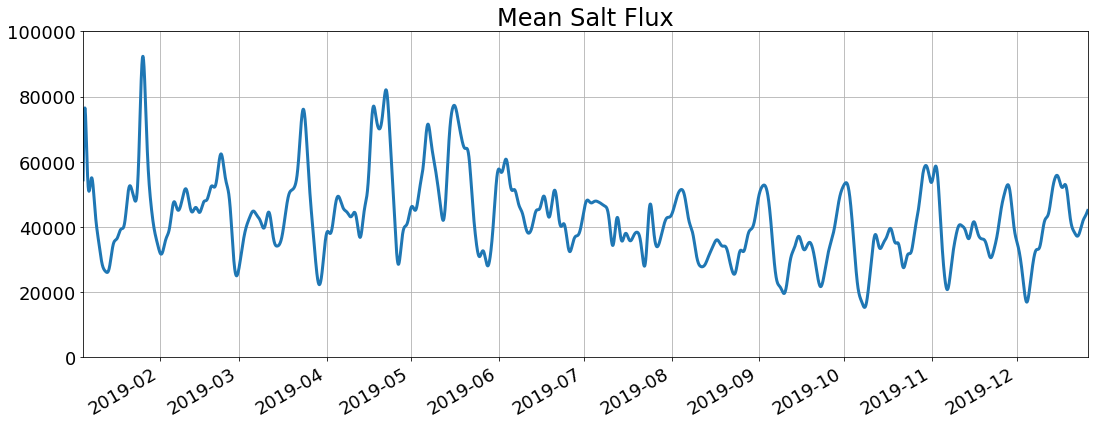

In [123]:
F0.plot(ylim=[0, 100000],aspect=3, size=6,linewidth=3)
plt.xlim(pd.Timestamp('2019-01-05'), pd.Timestamp('2019-12-26'))
plt.xlabel('')
plt.rcParams['font.size'] = '20'
plt.title('Mean Salt Flux')
plt.grid()

### 2. Estuarine Exchange Flow
$ \large v_e (x,z,t) = \frac{\left\langle v_i \, \mathrm{d}A \right\rangle}{dA_0}  - v_0 \\
\large s_e (x,z,t) = \frac{\left\langle s_i \, \mathrm{d}A \right\rangle}{dA_0}  - v_0 $

In [32]:
vei = xr.apply_ufunc(filtfilt_butter,
                   (vi*dA).chunk(dict(ocean_time=-1)),
                   Cf,
                   fs,
                   order_butter,
                   'ocean_time', 
                   dask='parallelized',
                   #vectorize=True,
                   #allow_rechunk=True,
                   input_core_dims=[["ocean_time"],[],[],[],[]],  # list with one entry per arg
                   output_core_dims=[["ocean_time"]],  # returned data has one dimension   
                   output_dtypes=[Hz.dtype])  # one per output

In [33]:
sei = xr.apply_ufunc(filtfilt_butter,
                   (si*dA).chunk(dict(ocean_time=-1)),
                   Cf,
                   fs,
                   order_butter,
                   'ocean_time', 
                   dask='parallelized',
                   #vectorize=True,
                   #allow_rechunk=True,
                   input_core_dims=[["ocean_time"],[],[],[],[]],  # list with one entry per arg
                   output_core_dims=[["ocean_time"]],  # returned data has one dimension   
                   output_dtypes=[Hz.dtype])  # one per output

In [34]:
ve=vei/dAo-v0
se=sei/dAo-s0

In [35]:
Fe = (ve*se*dAo.sum(axis=0).sum(axis=0)).sum(axis=0).sum(axis=0)

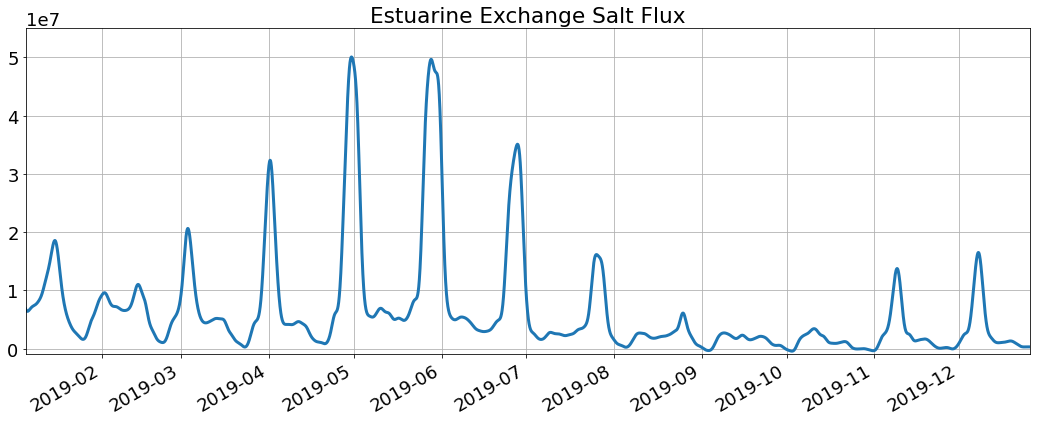

In [36]:
Fe.plot(ylim=[-1000000, 55000000],aspect=3, size=6,linewidth=3)
plt.xlim(pd.Timestamp('2019-01-05'), pd.Timestamp('2019-12-26'))
plt.xlabel('')
plt.rcParams['font.size'] = '18'
plt.title('Estuarine Exchange Salt Flux')
plt.grid()

### 3. Tidal Shear Dispersion
$ \large v_t (x,z,t) = v-v_e -v_0 \\
\large s_t (x,z,t) = s-s_e -s_0$

In [37]:
vt = vi-ve-v0;
st = si-se-s0;

In [38]:
Ft = ((vt*st*dAo.sum(axis=0).sum(axis=0)).sum(axis=1).sum(axis=1)).compute()

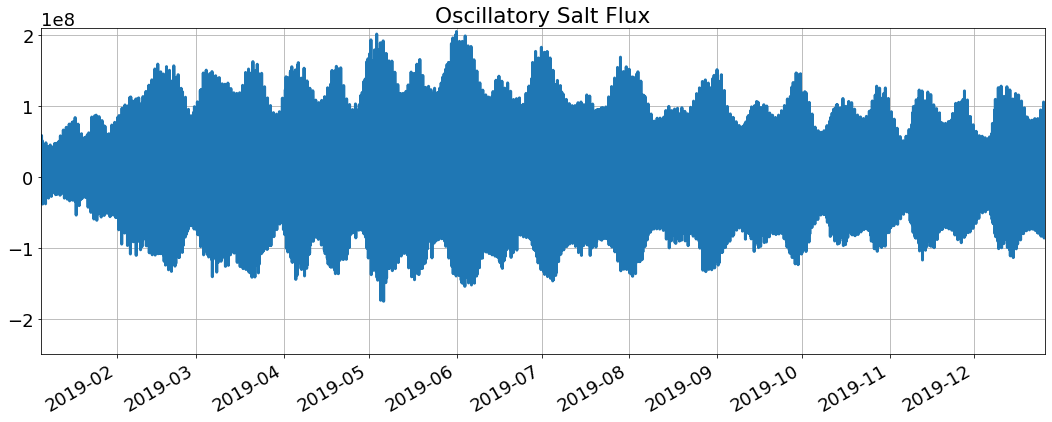

In [39]:
Ft.plot(ylim=[-250000000, 210000000],aspect=3, size=6,linewidth=3)
plt.xlim(pd.Timestamp('2019-01-05'), pd.Timestamp('2019-12-26'))
plt.xlabel('')
plt.rcParams['font.size'] = '18'
plt.title('Oscillatory Salt Flux')
plt.grid()

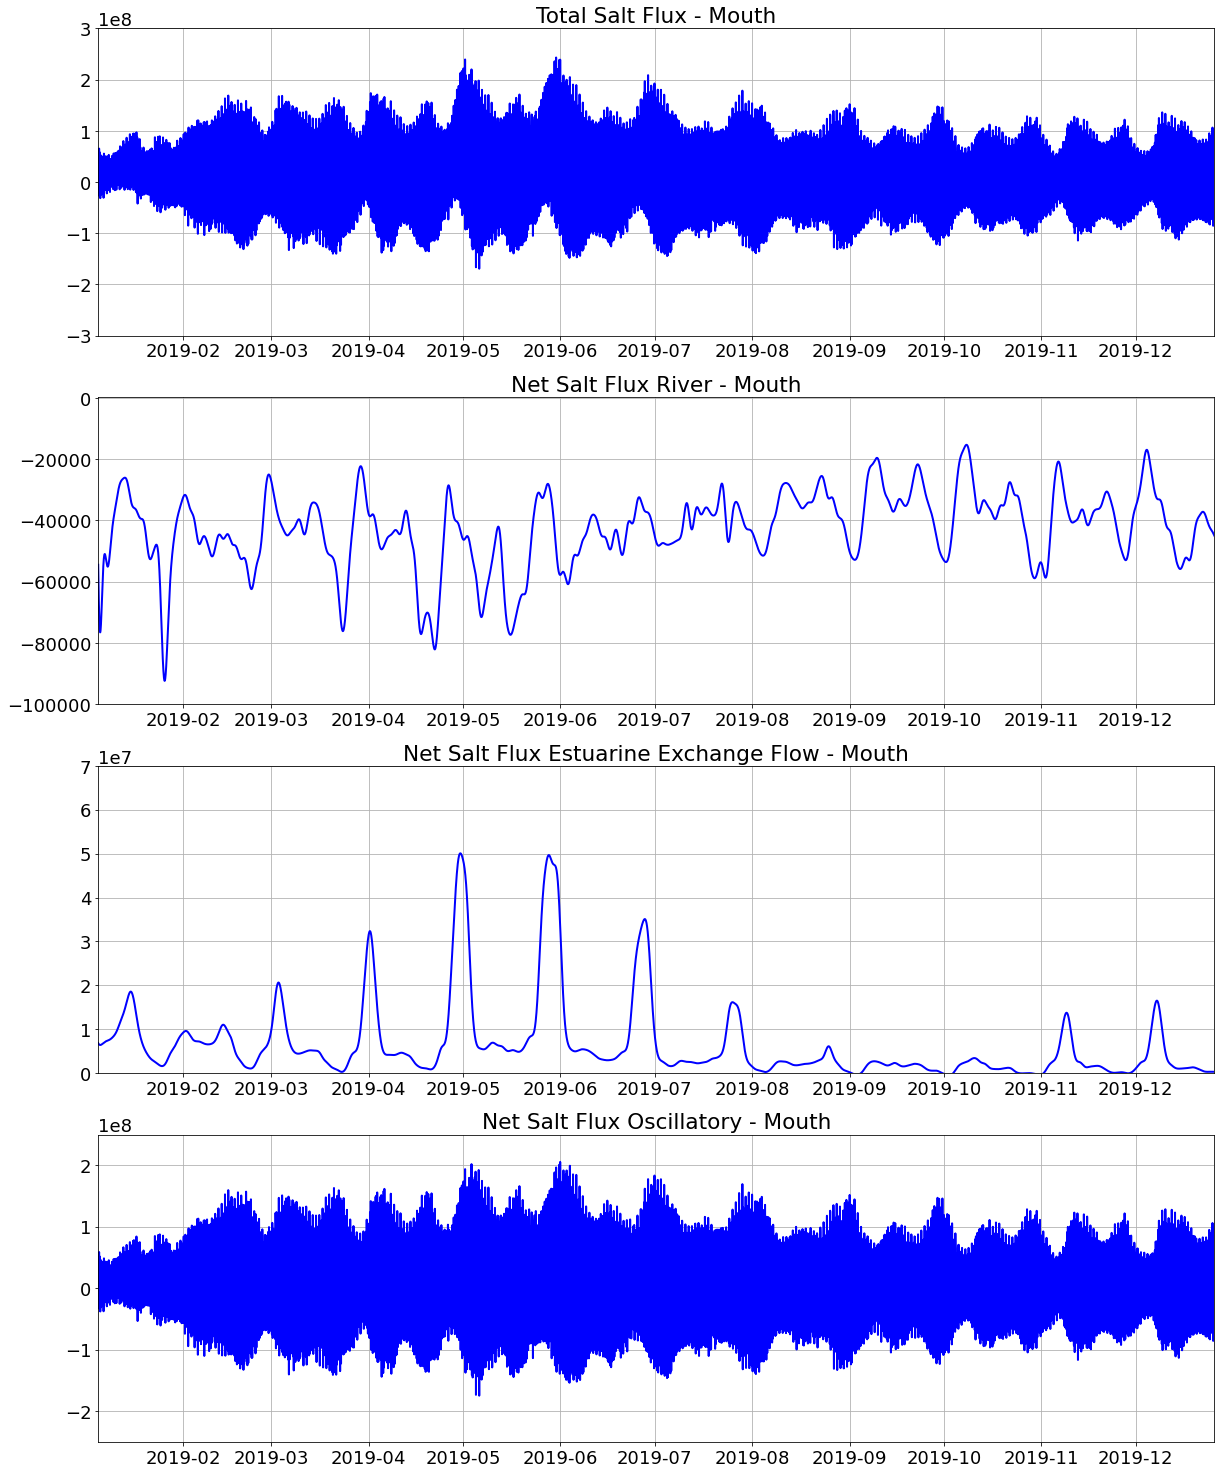

In [162]:
fig, axs = plt.subplots(4,figsize=(20,26))
fig.suptitle('')

axs[0].plot(ds1['ocean_time'],(F0+Fe+Ft),color='blue',linewidth=2)
axs[0].set_ylim([-300000000, 300000000])
axs[0].set_xlim(pd.Timestamp('2019-01-05'), pd.Timestamp('2019-12-26'))
axs[0].grid()

axs[1].plot(ds1['ocean_time'],-1*F0,color='blue',linewidth=2)
axs[1].set_ylim([-100000, 200])
axs[1].set_xlim(pd.Timestamp('2019-01-05'), pd.Timestamp('2019-12-26'))
axs[1].grid()

axs[2].plot(ds1['ocean_time'],Fe,color='blue',linewidth=2)
axs[2].set_ylim([0, 70000000])
axs[2].set_xlim(pd.Timestamp('2019-01-05'), pd.Timestamp('2019-12-26'))
axs[2].grid()

axs[3].plot(ds1['ocean_time'],Ft,color='blue',linewidth=2)
axs[3].set_ylim([-250000000, 250000000])
axs[3].set_xlim(pd.Timestamp('2019-01-05'), pd.Timestamp('2019-12-26'))
axs[3].grid()


plt.rcParams['font.size'] = '18'
axs[0].set_title('Total Salt Flux - Mouth')
axs[1].set_title('Net Salt Flux River - Mouth')
axs[2].set_title('Net Salt Flux Estuarine Exchange Flow - Mouth')
axs[3].set_title('Net Salt Flux Oscillatory - Mouth')

# plt.savefig('SaltFlux_2019_TideRun_Mouth.png',facecolor='white', edgecolor='none')

In [41]:
nu = Ft/(Fe+Ft)

(-10.0, 10.0)

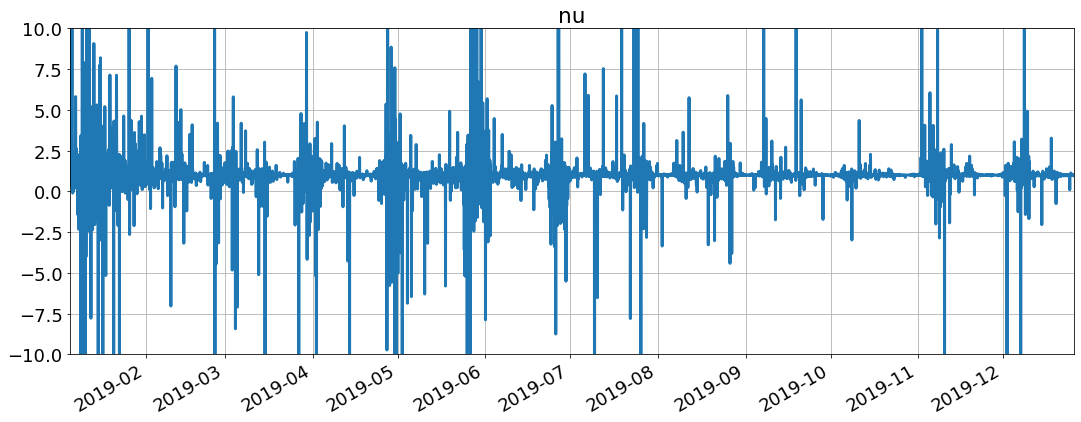

In [42]:
nu.plot(aspect=3, size=6,linewidth=3)
plt.xlim(pd.Timestamp('2019-01-05'), pd.Timestamp('2019-12-26'))
plt.xlabel('')
plt.rcParams['font.size'] = '18'
plt.title('nu')
plt.grid()
plt.ylim([-10, 10])

### Save data to netcdf file

In [43]:
ds_tidal_mouth = xr.Dataset({})
ds_tidal_mouth['Fs']=-1*(F0+Fe+Ft)
ds_tidal_mouth['F0']=-1*F0
ds_tidal_mouth['Fe']=Fe
ds_tidal_mouth['Ft']=Ft
ds_tidal_mouth['time']=ds1['ocean_time']


In [44]:
ds_tidal_mouth.to_netcdf("Salt_Flux_2019_testcoawst_tidal_mouth.nc")

# Go upstream to RM 54 and see what happens

In [45]:
x2 = np.arange(24,80,1)
y2 = np.arange(452,453,1)
y2 = np.repeat(y2,56)

In [46]:
target_x2 = xr.DataArray(x2,dims=["points"])
target_y2 = xr.DataArray(y2,dims=["points"])

In [47]:
lon2 = ds1['lon_rho'].isel(xi_rho=target_x2,eta_rho=target_y2)
lat2 = ds1['lat_rho'].isel(xi_rho=target_x2,eta_rho=target_y2)

(-75.6336721410152, -74.5539997447622, 38.57677062757692, 40.22643263298771)

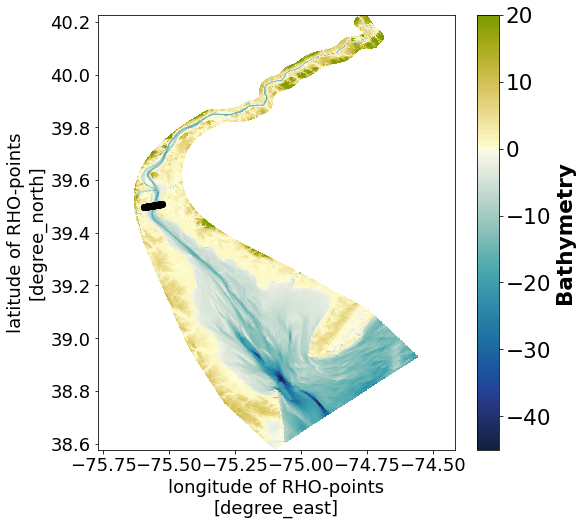

In [48]:
fig,ax1 = plt.subplots(figsize=(8,8))

newcmap = cm.cm.tools.crop(cm.cm.delta,vmin=-45,vmax=20,pivot=0)

da = -1*ds1['h']
p1 = da.plot(ax=ax1,x='lon_rho', y='lat_rho',cmap=newcmap,vmin=-45,vmax=20,add_colorbar=False)

cb = plt.colorbar(p1,ax=ax1)
cb.set_label(label="Bathymetry",size='large',weight='bold')
cb.ax.tick_params(labelsize='large')

# plt.plot(lon,lat,'ko')
plt.plot(lon2,lat2,'ko')

#fig.tight_layout()
ax1.axis('equal')

#### Calculate Hz - cell thickness

In [49]:
dz2 = ds1['z_w'].isel(xi_rho=target_x2,eta_rho=target_y2).compute()

In [50]:
Hz2 = dz2.diff(n=1,dim='s_w').swap_dims({'s_w':'s_rho'})

#### Calculate dx - cell width

In [51]:
dx2 =  1/ds1['pm'].isel(xi_rho=target_x2,eta_rho=target_y2).compute()

#### Calculate Area

In [52]:
dA2 = dx2*Hz2

# Calculate Salt Flux
##### Following Aristizabal and Chant 2013

$ \LARGE F_s = \left\langle \iint v s \, \mathrm{d}A \right\rangle = F_0 + F_E + F_t $

In [53]:
nt = len(ds1['ocean_time'])

the persist() from above might affect this computation...

In [54]:
vi2 = ds1['v'].isel(xi_v=target_x2,eta_v=target_y2).chunk({'ocean_time':nt}).persist()

In [55]:
si2 = ds1['salt'].isel(xi_rho=target_x2,eta_rho=target_y2).chunk({'ocean_time':nt}).persist()

In [56]:
Ao2 = xr.apply_ufunc(filtfilt_butter,
                   (dA2.sum(axis=0).sum(axis=0)).chunk(dict(ocean_time=-1)),
                   Cf,
                   fs,
                   order_butter,
                   'ocean_time', 
                   dask='parallelized',
                   #vectorize=True,
                   #allow_rechunk=True,
                   input_core_dims=[["ocean_time"],[],[],[],[]],  # list with one entry per arg
                   output_core_dims=[["ocean_time"]],  # returned data has one dimension   
                   output_dtypes=[Hz.dtype])  # one per output

In [57]:
dAo2 = xr.apply_ufunc(filtfilt_butter,
                   dA2.chunk(dict(ocean_time=-1)),
                   Cf,
                   fs,
                   order_butter,
                   'ocean_time', 
                   dask='parallelized',
                   #vectorize=True,
                   #allow_rechunk=True,
                   input_core_dims=[["ocean_time"],[],[],[],[]],  # list with one entry per arg
                   output_core_dims=[["ocean_time"]],  # returned data has one dimension   
                   output_dtypes=[Hz.dtype])  # one per output

### 1. River Salt Flux
$ \large F_0 = -Q_0 S_0 = -v_0 A_0 s_0$

$ \large v_0 (t) = \frac{1}{A_0} \left\langle \iint v_i \,  \mathrm{d}A \right\rangle \\
\large s_0 (t) = \frac{1}{A_0} \left\langle \iint s_i \,  \mathrm{d}A \right\rangle$

In [58]:
v0i2 = (vi2*dA2).sum(axis=1).sum(axis=1)
s0i2 = (si2*dA2).sum(axis=1).sum(axis=1)

In [59]:
Cf = 32
fs = 1
order_butter=6
v02 = butter_filt(v0i2,Cf,fs,order_butter)/Ao2
s02 = butter_filt(s0i2,Cf,fs,order_butter)/Ao2

In [60]:
F02 = -1*v02*dAo2.sum(axis=0).sum(axis=0)*s02

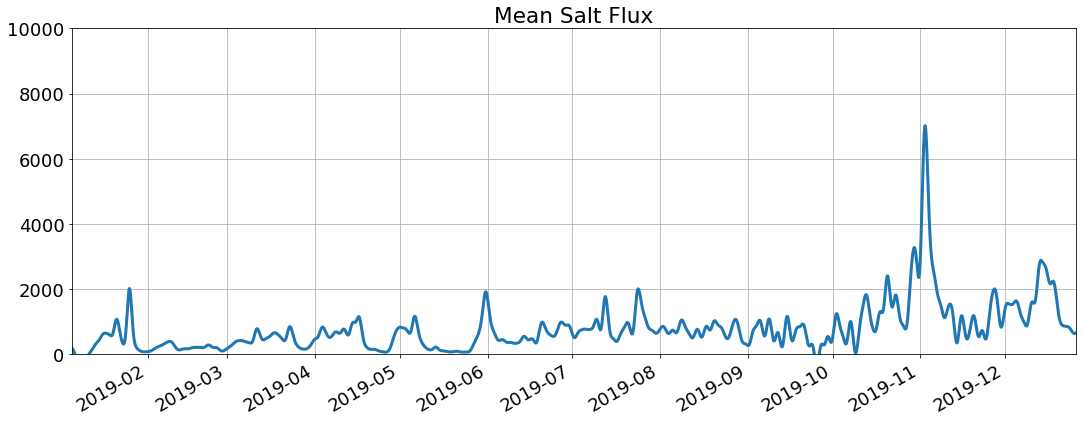

In [74]:
F02.plot(ylim=[0, 10000],aspect=3, size=6,linewidth=3)
plt.xlim(pd.Timestamp('2019-01-05'), pd.Timestamp('2019-12-26'))
plt.xlabel('')
plt.rcParams['font.size'] = '18'
plt.title('Mean Salt Flux')
plt.grid()

### 2. Estuarine Exchange Flow
$ \large v_e (x,z,t) = \frac{\left\langle v_i \, \mathrm{d}A \right\rangle}{dA_0}  - v_0 \\
\large s_e (x,z,t) = \frac{\left\langle s_i \, \mathrm{d}A \right\rangle}{dA_0}  - v_0 $

In [62]:
vei2 = xr.apply_ufunc(filtfilt_butter,
                   (vi2*dA2).chunk(dict(ocean_time=-1)),
                   Cf,
                   fs,
                   order_butter,
                   'ocean_time', 
                   dask='parallelized',
                   #vectorize=True,
                   #allow_rechunk=True,
                   input_core_dims=[["ocean_time"],[],[],[],[]],  # list with one entry per arg
                   output_core_dims=[["ocean_time"]],  # returned data has one dimension   
                   output_dtypes=[Hz.dtype])  # one per output

In [63]:
sei2 = xr.apply_ufunc(filtfilt_butter,
                   (si2*dA2).chunk(dict(ocean_time=-1)),
                   Cf,
                   fs,
                   order_butter,
                   'ocean_time', 
                   dask='parallelized',
                   #vectorize=True,
                   #allow_rechunk=True,
                   input_core_dims=[["ocean_time"],[],[],[],[]],  # list with one entry per arg
                   output_core_dims=[["ocean_time"]],  # returned data has one dimension   
                   output_dtypes=[Hz.dtype])  # one per output

In [64]:
ve2=vei2/dAo2-v02
se2=sei2/dAo2-s02

In [65]:
Fe2 = (ve2*se2*dAo2.sum(axis=0).sum(axis=0)).sum(axis=0).sum(axis=0)

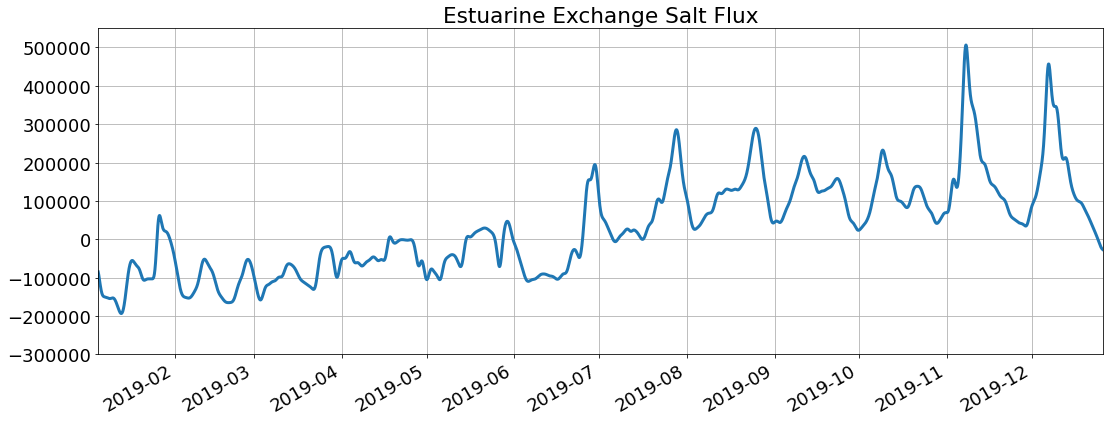

In [83]:
Fe2.plot(ylim=[-300000, 550000],aspect=3, size=6,linewidth=3)
plt.xlim(pd.Timestamp('2019-01-05'), pd.Timestamp('2019-12-26'))
plt.xlabel('')
plt.rcParams['font.size'] = '18'
plt.title('Estuarine Exchange Salt Flux')
plt.grid()

### 3. Tidal Shear Dispersion
$ \large v_t (x,z,t) = v-v_e -v_0 \\
\large s_t (x,z,t) = s-s_e -s_0$

In [67]:
vt2 = vi2-ve2-v02;
st2 = si2-se2-s02;

In [68]:
Ft2 = ((vt2*st2*dAo2.sum(axis=0).sum(axis=0)).sum(axis=1).sum(axis=1)).compute()

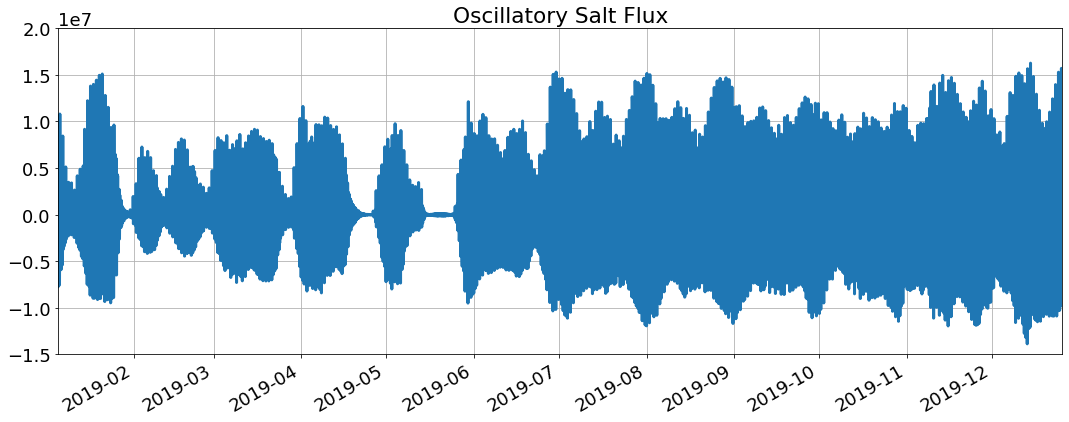

In [85]:
Ft2.plot(ylim=[-15000000, 20000000],aspect=3, size=6,linewidth=3)
plt.xlim(pd.Timestamp('2019-01-05'), pd.Timestamp('2019-12-26'))
plt.xlabel('')
plt.rcParams['font.size'] = '18'
plt.title('Oscillatory Salt Flux')
plt.grid()

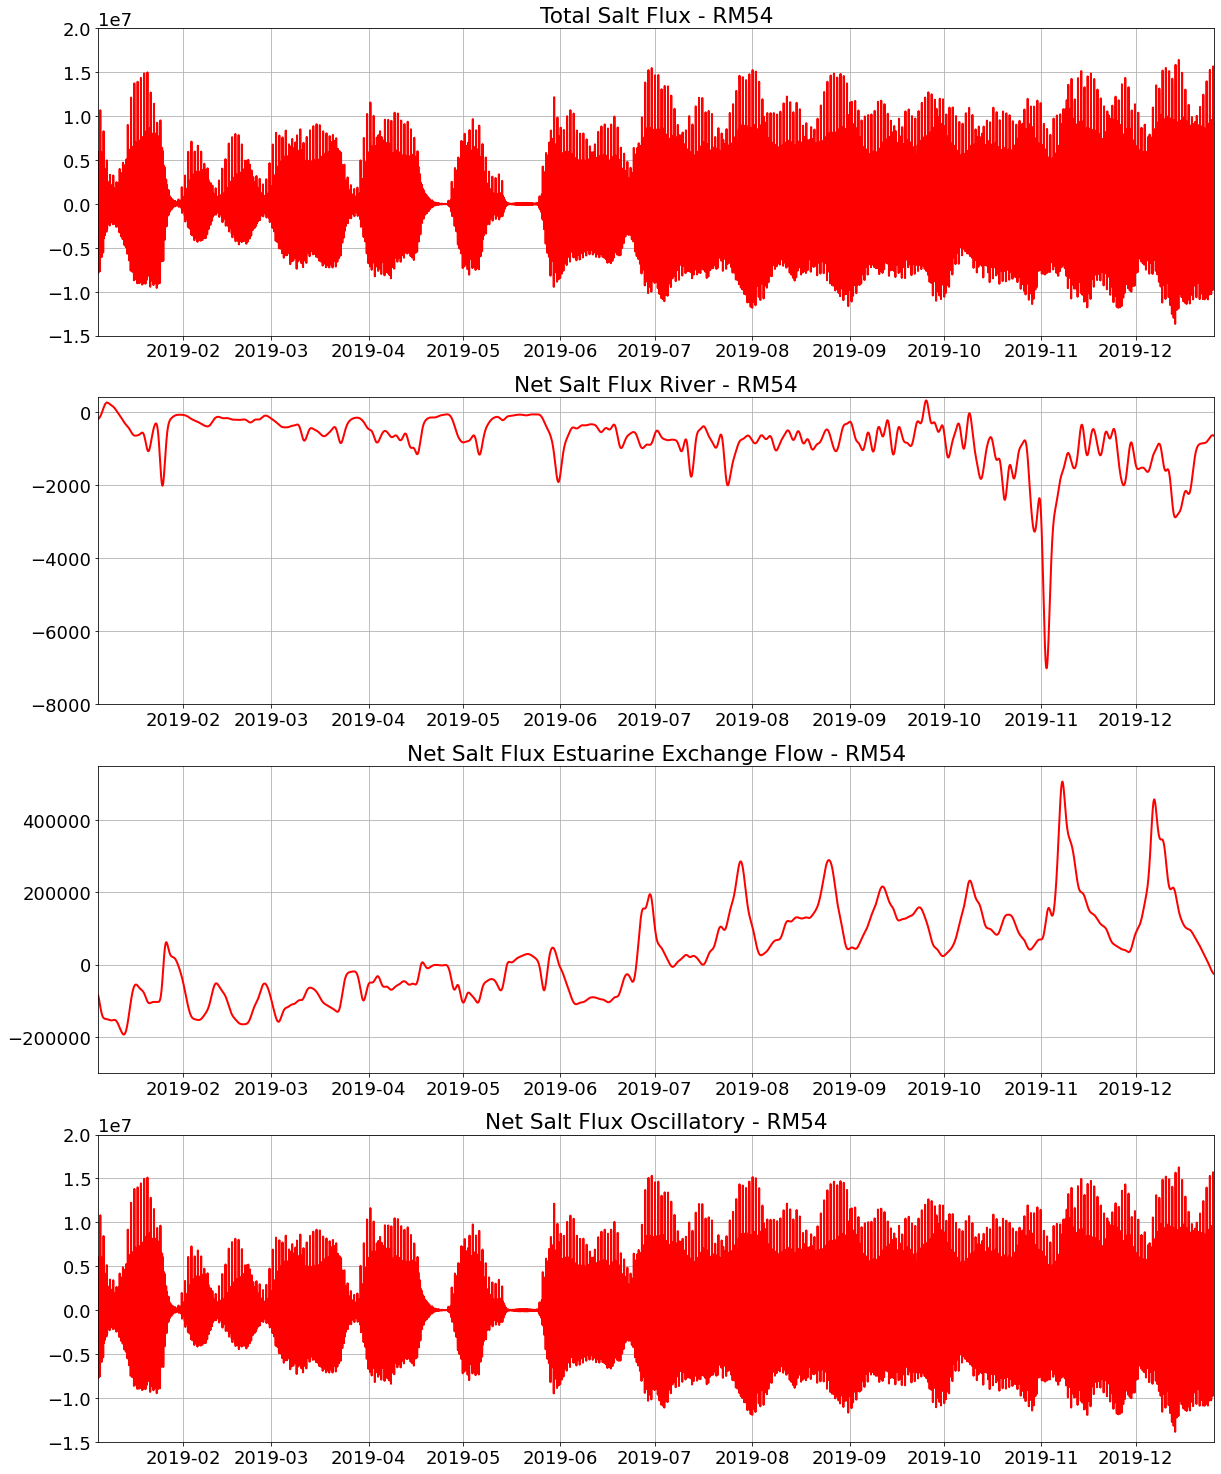

In [161]:
fig, axs = plt.subplots(4,figsize=(20,26))
fig.suptitle('')

axs[0].plot(ds1['ocean_time'],(F02+Fe2+Ft2),color='red',linewidth=2)
axs[0].set_ylim([-15000000, 20000000])
axs[0].set_xlim(pd.Timestamp('2019-01-05'), pd.Timestamp('2019-12-26'))
axs[0].grid()

axs[1].plot(ds1['ocean_time'],-1*F02,color='red',linewidth=2)
axs[1].set_ylim([-8000, 400])
axs[1].set_xlim(pd.Timestamp('2019-01-05'), pd.Timestamp('2019-12-26'))
axs[1].grid()

axs[2].plot(ds1['ocean_time'],Fe2,color='red',linewidth=2)
axs[2].set_ylim([-300000, 550000])
axs[2].set_xlim(pd.Timestamp('2019-01-05'), pd.Timestamp('2019-12-26'))
axs[2].grid()

axs[3].plot(ds1['ocean_time'],Ft2,color='red',linewidth=2)
axs[3].set_ylim([-15000000, 20000000])
axs[3].set_xlim(pd.Timestamp('2019-01-05'), pd.Timestamp('2019-12-26'))
axs[3].grid()


plt.rcParams['font.size'] = '18'
axs[0].set_title('Total Salt Flux - RM54')
axs[1].set_title('Net Salt Flux River - RM54')
axs[2].set_title('Net Salt Flux Estuarine Exchange Flow - RM54')
axs[3].set_title('Net Salt Flux Oscillatory - RM54')

# plt.savefig('SaltFlux_2019_TideRun_RM54.png',facecolor='white', edgecolor='none')

## Compare Transects

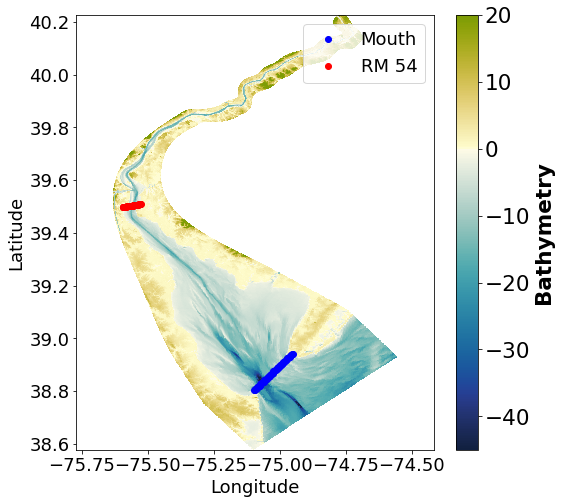

In [168]:
fig,ax1 = plt.subplots(figsize=(8,8))

newcmap = cm.cm.tools.crop(cm.cm.delta,vmin=-45,vmax=20,pivot=0)

da = -1*ds1['h']
p1 = da.plot(ax=ax1,x='lon_rho', y='lat_rho',cmap=newcmap,vmin=-45,vmax=20,add_colorbar=False)

cb = plt.colorbar(p1,ax=ax1)
cb.set_label(label="Bathymetry",size='large',weight='bold')
cb.ax.tick_params(labelsize='large')

plt.plot(lon,lat,'bo',label='Mouth')
plt.plot(lon2,lat2,'ro',label='RM 54')

ax1.axis('equal')

ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.legend()

#plt.savefig('SaltFlux_2019_TideRun_Transect_Map.png',facecolor='white', edgecolor='none')

In [71]:
nu2 = Ft2/(Fe2+Ft2)

In [117]:
nu1p = nu/50
nu2p = nu2/50

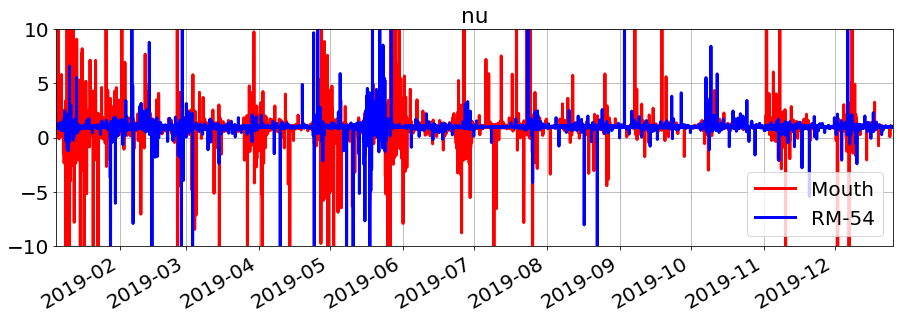

In [136]:
f, (ax1) = plt.subplots(figsize=(15, 4))

nu.plot.line(ax=ax1,linewidth=3,color='red',label='Mouth')
nu2.plot.line(ax=ax1,linewidth=3,color='blue',label='RM-54')
plt.legend()
plt.xlim(pd.Timestamp('2019-01-05'), pd.Timestamp('2019-12-26'))
plt.xlabel('')
plt.rcParams['font.size'] = '18'
plt.title('nu')
plt.grid()
plt.ylim([-10, 10])
plt.show()

### Save data to netcdf file

In [121]:
ds_tidal_rm54 = xr.Dataset({})
ds_tidal_rm54['Fs']=-1*(F02+Fe2+Ft2)
ds_tidal_rm54['F0']=-1*F02
ds_tidal_rm54['Fe']=Fe2
ds_tidal_rm54['Ft']=Ft2
ds_tidal_rm54['time']=ds1['ocean_time']

In [122]:
ds_tidal_rm54.to_netcdf("Salt_Flux_2019_testcoawst_tidal_rm54.nc")

In [128]:
Fs1 = (F0+Fe+Ft)
Fs2 = (F02+Fe2+Ft2)
diff_Fs = Fs1-Fs2

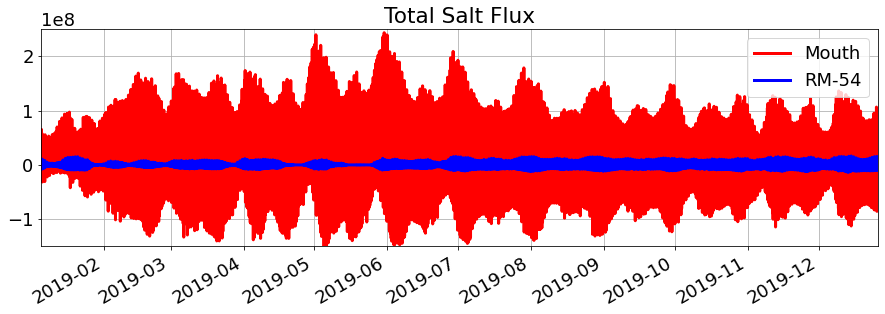

In [139]:
f, (ax1) = plt.subplots(4,figsize=(15, 4))

Fs1.plot.line(ax=ax1,linewidth=3,color='red',label='Mouth')
Fs2.plot.line(ax=ax1,linewidth=3,color='blue',label='RM-54')
plt.legend()
plt.xlim(pd.Timestamp('2019-01-05'), pd.Timestamp('2019-12-26'))
plt.xlabel('')
plt.rcParams['font.size'] = '18'
plt.title('Total Salt Flux')
plt.grid()
plt.ylim([-150000000, 250000000])
plt.show()


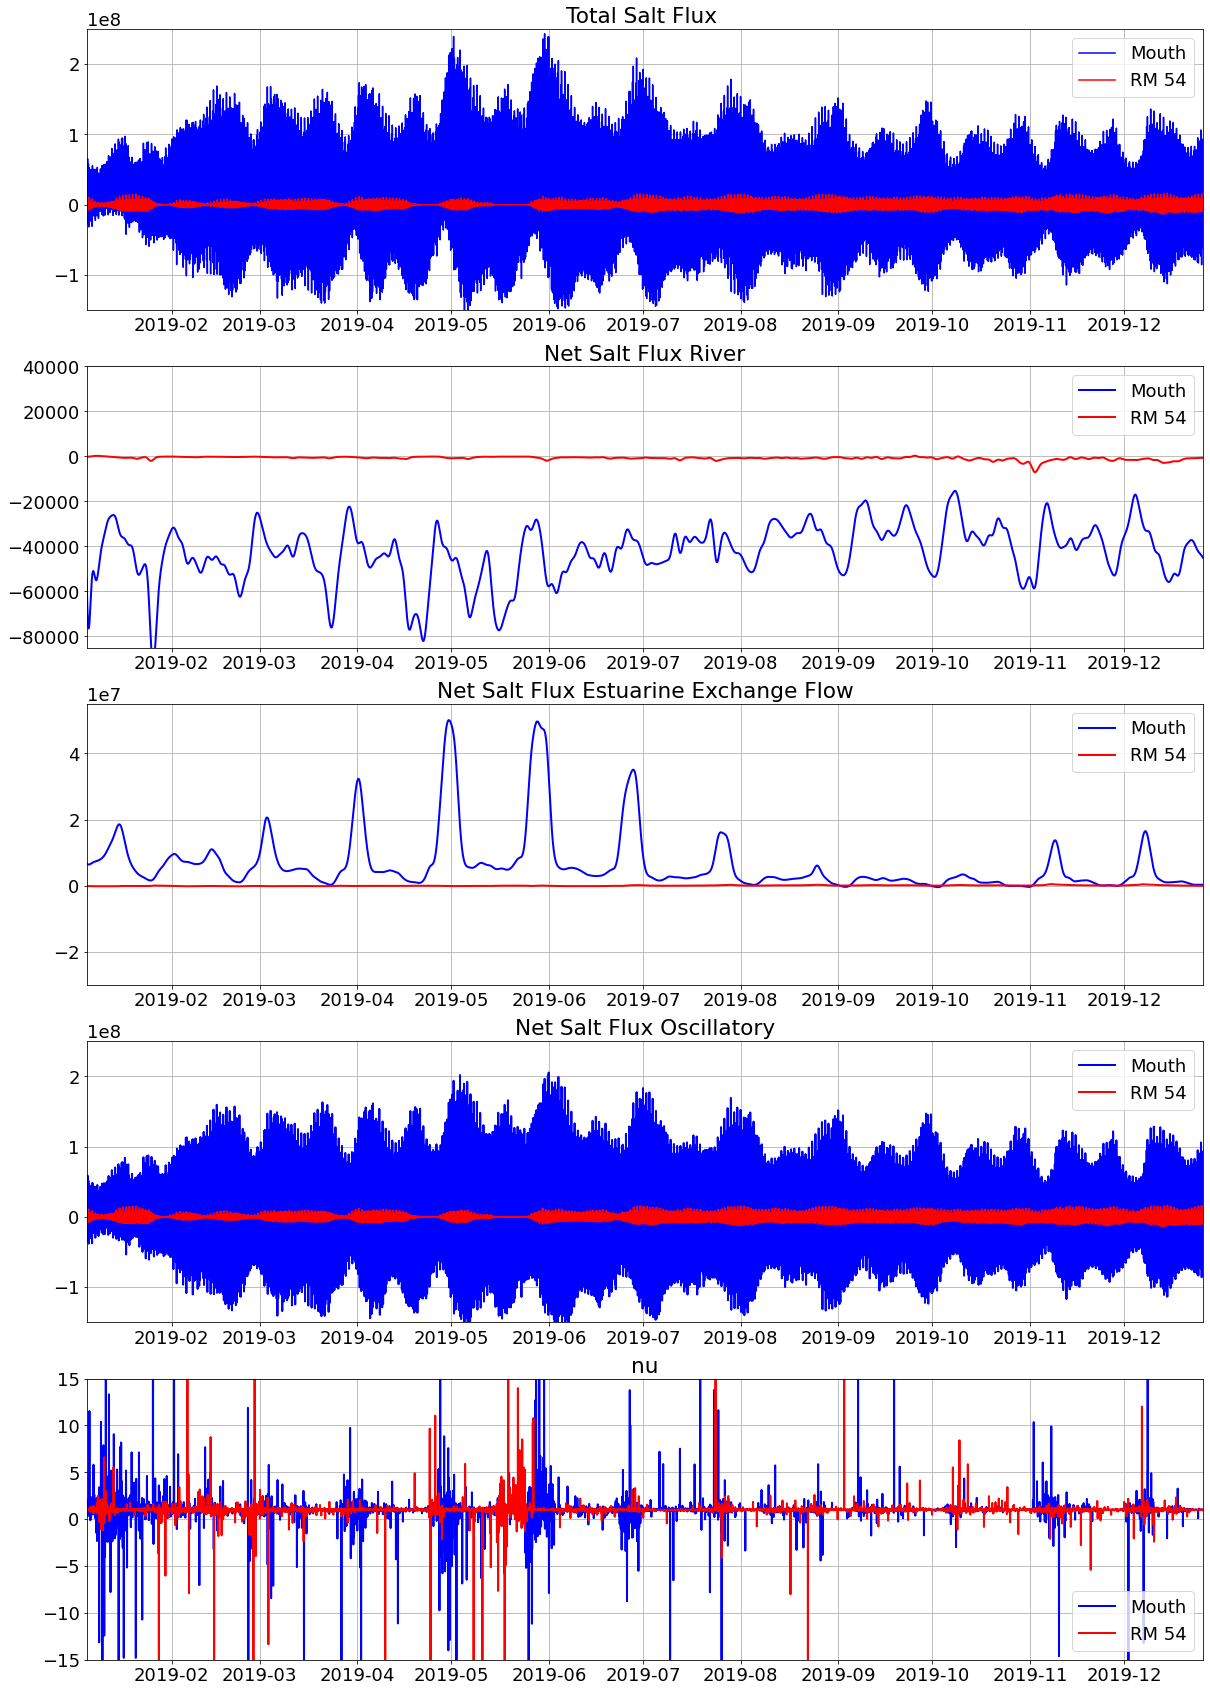

In [160]:
fig, axs = plt.subplots(5,figsize=(20,30))
fig.suptitle('')

axs[0].plot(ds1['ocean_time'],Fs1,color='blue',label='Mouth')
axs[0].plot(ds1['ocean_time'],Fs2,color='red',label='RM 54')
axs[0].set_ylim([-150000000, 250000000])
axs[0].set_xlim(pd.Timestamp('2019-01-05'), pd.Timestamp('2019-12-26'))
axs[0].grid()
axs[0].legend()

axs[1].plot(ds1['ocean_time'],-1*F0,color='blue',linewidth=2,label='Mouth')
axs[1].plot(ds1['ocean_time'],-1*F02,color='red',linewidth=2,label='RM 54')
axs[1].set_ylim([-85000, 40000])
axs[1].set_xlim(pd.Timestamp('2019-01-05'), pd.Timestamp('2019-12-26'))
axs[1].grid()
axs[1].legend()

axs[2].plot(ds1['ocean_time'],Fe,color='blue',linewidth=2,label='Mouth')
axs[2].plot(ds1['ocean_time'],Fe2,color='red',linewidth=2,label='RM 54')
axs[2].set_ylim([-30000000, 55000000])
axs[2].set_xlim(pd.Timestamp('2019-01-05'), pd.Timestamp('2019-12-26'))
axs[2].grid()
axs[2].legend()

axs[3].plot(ds1['ocean_time'],Ft,color='blue',linewidth=2,label='Mouth')
axs[3].plot(ds1['ocean_time'],Ft2,color='red',linewidth=2,label='RM 54')
axs[3].set_ylim([-150000000, 250000000])
axs[3].set_xlim(pd.Timestamp('2019-01-05'), pd.Timestamp('2019-12-26'))
axs[3].grid()
axs[3].legend()

axs[4].plot(ds1['ocean_time'],nu,color='blue',linewidth=2,label='Mouth')
axs[4].plot(ds1['ocean_time'],nu2,color='red',linewidth=2,label='RM 54')
axs[4].set_ylim([-15,15])
axs[4].set_xlim(pd.Timestamp('2019-01-05'), pd.Timestamp('2019-12-26'))
axs[4].grid()
axs[4].legend()

plt.rcParams['font.size'] = '18'
axs[0].set_title('Total Salt Flux ')
axs[1].set_title('Net Salt Flux River')
axs[2].set_title('Net Salt Flux Estuarine Exchange Flow')
axs[3].set_title('Net Salt Flux Oscillatory')
axs[4].set_title('nu')

# plt.savefig('SaltFlux_2019_TideRun_Mouth_RM54.png',facecolor='white', edgecolor='none')